<a href="https://colab.research.google.com/github/PimHoefmans/ProjectH2/blob/main/Project_H2_Hypothesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
import pandas as pd

# get credentials
auth.authenticate_user()

query = '''
SELECT *
FROM `pure-heuristic-417807.project.Credit_Final`
'''
df = pd.read_gbq(query, project_id="pure-heuristic-417807")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
!pip install pycaret
import pycaret
from pycaret.classification import setup, compare_models, plot_model, tune_model

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  Int64  
 1   CODE_GENDER          36457 non-null  object 
 2   CNT_CHILDREN         36457 non-null  Int64  
 3   AMT_INCOME_TOTAL     36457 non-null  float64
 4   NAME_EDUCATION_TYPE  36457 non-null  object 
 5   NAME_FAMILY_STATUS   36457 non-null  object 
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_HOUSING_TYPE    36457 non-null  object 
 8   DAYS_EMPLOYED        36457 non-null  Int64  
 9   FLAG_WORK_PHONE      36457 non-null  Int64  
 10  FLAG_PHONE           36457 non-null  Int64  
 11  FLAG_EMAIL           36457 non-null  Int64  
 12  OCCUPATION_TYPE      36457 non-null  object 
 13  CNT_FAM_MEMBERS      36457 non-null  float64
 14  BIRTHDAY             36457 non-null  dbdate 
 15  OWN_CAR              36457 non-null 

In [ ]:
df.isnull().sum()/df.shape[0]*100

ID                     0.0
CODE_GENDER            0.0
CNT_CHILDREN           0.0
AMT_INCOME_TOTAL       0.0
NAME_EDUCATION_TYPE    0.0
NAME_FAMILY_STATUS     0.0
NAME_INCOME_TYPE       0.0
NAME_HOUSING_TYPE      0.0
DAYS_EMPLOYED          0.0
FLAG_WORK_PHONE        0.0
FLAG_PHONE             0.0
FLAG_EMAIL             0.0
OCCUPATION_TYPE        0.0
CNT_FAM_MEMBERS        0.0
BIRTHDAY               0.0
OWN_CAR                0.0
OWN_REALTY             0.0
AGE                    0.0
AGE_COHORTS            0.0
CREDIT_DATE            0.0
END_STATUS             0.0
dtype: float64

In [ ]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,OWN_CAR,OWN_REALTY,AGE
count,36457.0,36457.0,3.645700e+04,36457.0,36457.0,36457.0,36457.0,36457.000000,36457.0,36457.0,36457.0
mean,5078226.996544,0.430315,1.866857e+05,59262.935568,0.225526,0.294813,0.089722,2.198453,0.379708,0.672189,43.901116
std,41875.240788,0.742367,1.017892e+05,137651.334859,0.417934,0.455965,0.285787,0.911686,0.485321,0.469422,11.500423
min,5008804.0,0.0,2.700000e+04,-15713.0,0.0,0.0,0.0,1.000000,0.0,0.0,21.0
25%,5042028.0,0.0,1.215000e+05,-3153.0,0.0,0.0,0.0,2.000000,0.0,0.0,34.0
50%,5074614.0,0.0,1.575000e+05,-1552.0,0.0,0.0,0.0,2.000000,0.0,1.0,43.0
75%,5115396.0,1.0,2.250000e+05,-408.0,0.0,1.0,0.0,3.000000,1.0,1.0,53.0
max,5150487.0,19.0,1.575000e+06,365243.0,1.0,1.0,1.0,20.000000,1.0,1.0,69.0


In [ ]:
lst = list(df.select_dtypes('object').columns)

for i in lst :

  lb = LabelEncoder()

  df[i] = lb.fit_transform(df[i])

In [ ]:
df

,ID,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,...,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,BIRTHDAY,OWN_CAR,OWN_REALTY,AGE,AGE_COHORTS,CREDIT_DATE,END_STATUS
0,5046487,1,3,180000.0,4,1,0,1,-878,0,...,0,4,5.0,1981-03-21,1,0,43,3,2023-06-08,0
1,5042018,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2023-04-08,0
2,5042016,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2023-04-08,0
3,5042020,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2023-03-08,0
4,5042017,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2021-02-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5137462,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2021-10-08,1
36453,5137467,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2024-03-08,1
36454,5137463,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2021-03-08,1
36455,5137464,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2024-03-08,1


In [ ]:
X = df[["AMT_INCOME_TOTAL","DAYS_EMPLOYED","NAME_INCOME_TYPE","NAME_HOUSING_TYPE", "OWN_CAR","OWN_REALTY"]]
y = df["END_STATUS"]
#df["AMT_INCOME_TOTAL"] = np.floor(pd.to_numeric(df['AMT_INCOME_TOTAL'], errors='coerce')).astype('int64') This was just here to try and get SMOTE to work, alas.
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AMT_INCOME_TOTAL   36457 non-null  float64
 1   DAYS_EMPLOYED      36457 non-null  Int64  
 2   NAME_INCOME_TYPE   36457 non-null  int64  
 3   NAME_HOUSING_TYPE  36457 non-null  int64  
 4   OWN_CAR            36457 non-null  Int64  
 5   OWN_REALTY         36457 non-null  Int64  
dtypes: Int64(3), float64(1), int64(2)
memory usage: 1.8 MB


In [ ]:
# smote = SMOTE()
# X_balance, Y_balance = smote.fit_resample(X, y)

#Not sure how this works yet

In [ ]:
columns_to_filter = ['DAYS_EMPLOYED','AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN']

# Calculate lower and upper bounds for each selected column
lower_bounds = df[columns_to_filter].quantile(0.05)
upper_bounds = df[columns_to_filter].quantile(0.90)

# Define the boundaries for outlier removal
lower_bound_limits = lower_bounds - 0.05 * (upper_bounds - lower_bounds)
upper_bound_limits = upper_bounds + 0.05 * (upper_bounds - lower_bounds)

# Filter out the rows containing outliers in any of the selected columns
df = df[~((df[columns_to_filter] < lower_bound_limits) | (df[columns_to_filter] > upper_bound_limits)).any(axis=1)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
log_model = LogisticRegression()
log_model.fit(X, y)

LogisticRegression()

In [ ]:
log_model.score(X_test, y_test)

0.5152678734686414

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29837 entries, 1 to 36456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   29837 non-null  Int64  
 1   CODE_GENDER          29837 non-null  int64  
 2   CNT_CHILDREN         29837 non-null  Int64  
 3   AMT_INCOME_TOTAL     29837 non-null  float64
 4   NAME_EDUCATION_TYPE  29837 non-null  int64  
 5   NAME_FAMILY_STATUS   29837 non-null  int64  
 6   NAME_INCOME_TYPE     29837 non-null  int64  
 7   NAME_HOUSING_TYPE    29837 non-null  int64  
 8   DAYS_EMPLOYED        29837 non-null  Int64  
 9   FLAG_WORK_PHONE      29837 non-null  Int64  
 10  FLAG_PHONE           29837 non-null  Int64  
 11  FLAG_EMAIL           29837 non-null  Int64  
 12  OCCUPATION_TYPE      29837 non-null  int64  
 13  CNT_FAM_MEMBERS      29837 non-null  float64
 14  BIRTHDAY             29837 non-null  dbdate 
 15  OWN_CAR              29837 non-null  Int6

In [ ]:
log_model_cv = LogisticRegression()

X = df[["AMT_INCOME_TOTAL","DAYS_EMPLOYED","NAME_INCOME_TYPE","NAME_HOUSING_TYPE"]]
y = df["END_STATUS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()    # same as before
model = LogisticRegression()   # put scaler and model together in one pipeline
pipeline = make_pipeline(scaler, model)
pipeline

# Train - in one go
pipeline.fit(X_train, y_train)
# This does it all for me:
#   - It fits the scaler
#   - It transforms the train data
#   - It fits the model on the transformed train data

# Score - in one go
pipeline.score(X_test, y_test)
# This does it all for me:
#   - It does NOT fit the scaler again (we don't want that)
#   - It transforms the test data
#   - It scores the model on the transformed test data

cv_score = cross_val_score(pipeline, X, y, cv=5)

print("The CV scores: ", cv_score)
print("Mean of the scores: ", cv_score.mean())

The CV scores:  [0.51926944 0.519437   0.49522373 0.51935646 0.51935646]
Mean of the scores:  0.5145286171800129


In [ ]:
#Can also do the encoding steps on its own!

set_up = setup(data = df, train_size = 0.8, target = "END_STATUS", normalize = True, session_id = 42,  ignore_features=["ID","BIRTHDAY",'CREDIT_DATE'])

,Description,Value
0,Session id,42
1,Target,END_STATUS
2,Target type,Binary
3,Original data shape,"(29837, 21)"
4,Transformed data shape,"(29837, 18)"
5,Transformed train set shape,"(23869, 18)"
6,Transformed test set shape,"(5968, 18)"
7,Ignore features,3
8,Numeric features,17
9,Preprocess,True


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6498,0.7135,0.6820,0.6569,0.6692,0.2975,0.2978,2.0880
dt,Decision Tree Classifier,0.6490,0.6922,0.6261,0.6746,0.6494,0.2990,0.2998,0.1370
et,Extra Trees Classifier,0.6488,0.7065,0.6346,0.6713,0.6524,0.2982,0.2987,1.5660
xgboost,Extreme Gradient Boosting,0.6242,0.6719,0.6627,0.6318,0.6468,0.2458,0.2462,0.2260
knn,K Neighbors Classifier,0.6196,0.6609,0.6545,0.6285,0.6411,0.2369,0.2372,1.1080
lightgbm,Light Gradient Boosting Machine,0.6034,0.6478,0.6896,0.6035,0.6435,0.2010,0.2034,2.0570
gbc,Gradient Boosting Classifier,0.5543,0.5779,0.7002,0.5563,0.6199,0.0978,0.1018,1.5630
ada,Ada Boost Classifier,0.5350,0.5461,0.6763,0.5420,0.6017,0.0593,0.0614,0.6140
qda,Quadratic Discriminant Analysis,0.5319,0.5436,0.6095,0.5440,0.5748,0.0579,0.0585,0.0670
lr,Logistic Regression,0.5231,0.5271,0.7293,0.5296,0.6136,0.0301,0.0329,0.7610


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

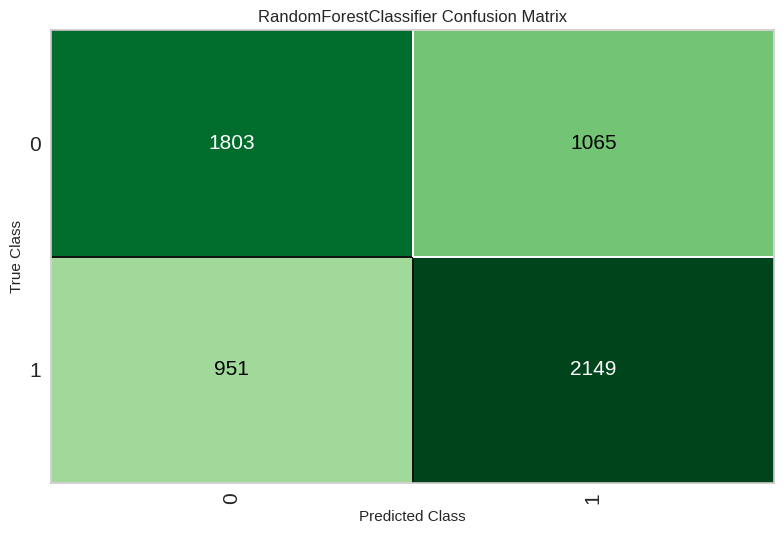

In [ ]:
plot_model(best_model, plot='confusion_matrix')

In [ ]:
#best_model_tuned = tune_model(best_model)

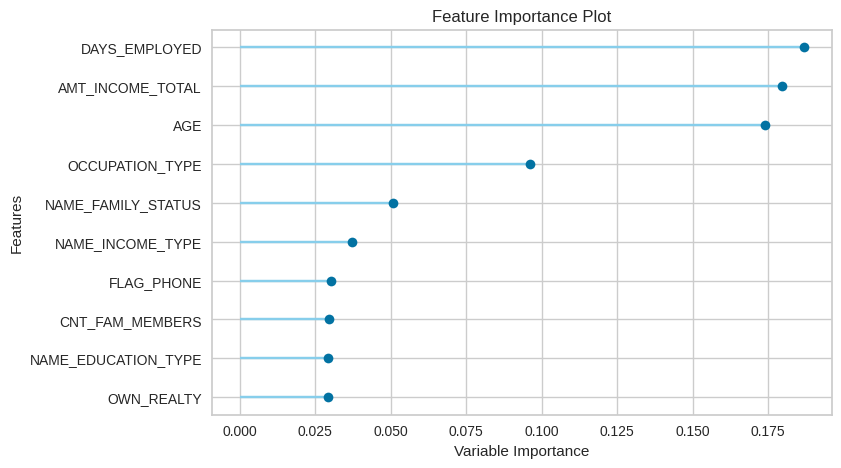

In [ ]:
plot_model(best_model,'feature')

In [ ]:
df

,ID,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,...,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,BIRTHDAY,OWN_CAR,OWN_REALTY,AGE,AGE_COHORTS,CREDIT_DATE,END_STATUS
1,5042018,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2023-04-08,0
2,5042016,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2023-04-08,0
3,5042020,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2023-03-08,0
4,5042017,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2021-02-08,0
5,5042019,1,0,180000.0,4,1,4,1,-126,0,...,0,4,2.0,1995-12-09,1,0,29,3,2021-01-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5137462,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2021-10-08,1
36453,5137467,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2024-03-08,1
36454,5137463,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2021-03-08,1
36455,5137464,0,0,135000.0,4,1,4,1,-869,0,...,0,14,2.0,1981-11-29,0,0,43,3,2024-03-08,1


In [ ]:
#!pip install streamlit
#import streamlit as st

In [ ]:
#st.altair_chart(df)